# Lab making predictions with logistic regression

## 1 Problem Definition 

## 2 Gather Data

## 3 Pre-process Data

## 4 Analyze Data

## 5 Prepare Data

## 6 Evaluate Models

## 7 Modeling

## 8 Publish

## <span style="color:#7B241C"> 1 Problem Definition </span>.

>We want to predict which films will be rented next month. Rented or not rented this is the quiestion to solve and the logistc regression is the model that will help us to solve such a question. William Shakespeare vibes

## <span style="color:#7B241C"> 2 Gather Data </span>.

>Data is downloaded from Sakila database. Variables downloaded as follow

| Column Name | Description |
| ----------- | ----------- |
| film_id | Unique identifiers for films |
| title | Film title |
| rental_duration | Duration in days |
| rental_rate | Cost in local currency for each rental |
| length | Movie length |
| replacement_cost | Cost in local currency for each Movie copy |
| rating | Movie rating |
| special_features | Extras content in the movie |
| Category | Movie category |
| num_tot_rentals | total number of rentals for the movie. How many times has been rented |
| num_stores_avability | In how many stores is this movie available |
| num_copies | How many copies are available |
| RENTED_LAST_MONTH | If the movie was rented latest month in the database |


**Import Libraries**

In [1]:
# Basic libraries
import pymysql
import pandas as pd # data manipulatioN
import numpy as np # numerical operations
import matplotlib.pyplot as plt # 2D visualizations
import seaborn as sns # high-resolution visualization
import warnings # warning messages management

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder # label encoding
from sklearn.model_selection import train_test_split # splitting data into train/test sets
from sklearn.linear_model import LogisticRegression # logistic model
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay # logistic metrics
from sklearn import metrics # moar metrics

# SQL connection
from getpass import getpass # To get the password without showing the input
from sqlalchemy import create_engine # route to the engine

# Settings
pd.set_option('display.max_columns', None) # display all columns
warnings.filterwarnings('ignore') # ignore warnings
#%matplotlib inline

password = getpass.getpass()
#Create connection
dbName = "sakila"
connection_string = 'mysql+pymysql://root:' + password + '@localhost/' + dbName
engine = create_engine(connection_string)

········


In [2]:
query = ''' with Num_rentals as (#Get number of rentals per movie
	select 
		film_id
        , count(*) as 'num_tot_rentals'
        , CASE WHEN MAX(rental_date) >= '2006-02-01' AND MAX(rental_date) < '2006-03-01' THEN TRUE ELSE FALSE END AS 'rented_last_month'
	from rental r
		inner join inventory i 
			on r.inventory_id=i.inventory_id
	group by i.film_id),
avaibility_store as (#Number of stores where movie is available
	select 
    t1.film_id
    , count(*) as 'num_stores_avability'
	from (
	select 
		distinct film_id, store_id
	from inventory) as t1
group by t1.film_id
),
num_copies as (select #Numbers of copies available to rent
		film_id
        , count(*) as 'num_copies'
        from inventory
        group by film_id)
select
	f.film_id
    , f.title
    , f.rental_duration
    , f.rental_rate
    , f.length
    , f.replacement_cost
    , f.rating
    , f.special_features
    , c.name as 'Category'
    , nr.num_tot_rentals
    , ast.num_stores_avability
    , nc.num_copies
    , nr.rented_last_month
from film f
	inner join film_category fc
		on fc.film_id=f.film_id
	inner join category c 
		on c.category_id=fc.category_id
	left join Num_rentals nr
		on nr.film_id=f.film_id
	left join avaibility_store ast
		on ast.film_id=f.film_id
	left join num_copies nc 
		on nc.film_id=f.film_id'''
data = pd.read_sql_query(query, engine)
#save the data in case I need to reload it. I don´t need to query the DB again.
data.to_csv('Raw_data_Sakila.csv', index=False)
data.head()

,film_id,title,rental_duration,rental_rate,length,replacement_cost,rating,special_features,Category,num_tot_rentals,num_stores_avability,num_copies,rented_last_month
0,19,AMADEUS HOLY,6,0.99,113,20.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",Action,21.0,2.0,6.0,1.0
1,21,AMERICAN CIRCUS,3,4.99,129,17.99,R,"Commentaries,Behind the Scenes",Action,22.0,2.0,6.0,1.0
2,29,ANTITRUST TOMATOES,5,2.99,168,11.99,NC-17,"Trailers,Commentaries,Deleted Scenes",Action,10.0,1.0,2.0,0.0
3,38,ARK RIDGEMONT,6,0.99,68,25.99,NC-17,"Trailers,Commentaries,Deleted Scenes,Behind th...",Action,NaN,NaN,NaN,NaN
4,56,BAREFOOT MANCHURIAN,6,2.99,129,15.99,G,"Trailers,Commentaries",Action,18.0,2.0,5.0,0.0


## <span style="color:#7B241C"> 3 Pre-process Data </span>.

 
>This step has been completed in iterations together with step 4. After some analysis I was adding cleaning steps here

**Here I separate numerical and categorical features.** 
 - df_numeric
 - df_object


In [3]:
    #Print info for the dataframe
    print('\n\n\nDescription of output data frame \n')
    data.info(
    )




Description of output data frame 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   film_id               1000 non-null   int64  
 1   title                 1000 non-null   object 
 2   rental_duration       1000 non-null   int64  
 3   rental_rate           1000 non-null   float64
 4   length                1000 non-null   int64  
 5   replacement_cost      1000 non-null   float64
 6   rating                1000 non-null   object 
 7   special_features      1000 non-null   object 
 8   Category              1000 non-null   object 
 9   num_tot_rentals       958 non-null    float64
 10  num_stores_avability  958 non-null    float64
 11  num_copies            958 non-null    float64
 12  rented_last_month     958 non-null    float64
dtypes: float64(6), int64(3), object(4)
memory usage: 101.7+ KB


In [16]:
#Standarize column names
cols = [col_name.upper().replace(' ', '_') for col_name in data.columns]
data.columns = cols

df_numeric=data.select_dtypes(include=["float", "int"])
df_object=data.select_dtypes(include=[object]) 

#Numeric variables cleaning
null_columns = df_numeric.columns[df_numeric.isna().sum() != 0].tolist()
print("\n\n\nNumerical columns that contains null values: \n ",null_columns,"\n nulls have been replaced 0\n\n\n")
#Put 0 in those which have nulls.
for  Column_to_change in null_columns:
    df_numeric[Column_to_change] = df_numeric[Column_to_change].fillna(0)

#Convert rented_last_month into boolean
df_numeric['RENTED_LAST_MONTH'] = df_numeric['RENTED_LAST_MONTH'].astype(bool)
    
#String variables cleaning
null_columns = df_object.columns[df_object.isna().sum() != 0].tolist()
print("Categorical columns that contains null values: \n ",null_columns, "\n nulls have been replaced with Unkown label\n\n\n")
#Put Unkwon in those which have nulls.
for  Column_to_change in null_columns:
    df_object[Column_to_change] = df_object[Column_to_change].fillna('Unknown') 
    
#This is also part of encoding. But it is the way I found to check if in the string we have the different words   
words = ['Commentary', 'Deleted Scenes', 'Behind the Scenes', 'Trailers']
for word in words:
    df_object[word] = df_object['SPECIAL_FEATURES'].str.contains(word).astype(bool)
df_object=df_object.drop(columns=['SPECIAL_FEATURES'])   #Removed the original column. We don´t need it anymore 

data_3=pd.concat([df_numeric, df_object], axis=1)
data_3.reset_index()
cols = [col_name.upper().replace(' ', '_') for col_name in data_3.columns]
data_3.columns = cols





Numerical columns that contains null values: 
  ['NUM_TOT_RENTALS', 'NUM_STORES_AVABILITY', 'NUM_COPIES', 'RENTED_LAST_MONTH'] 
 nulls have been replaced 0



Categorical columns that contains null values: 
  [] 
 nulls have been replaced with Unkown label





In [17]:
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   FILM_ID               1000 non-null   int64  
 1   RENTAL_DURATION       1000 non-null   int64  
 2   RENTAL_RATE           1000 non-null   float64
 3   LENGTH                1000 non-null   int64  
 4   REPLACEMENT_COST      1000 non-null   float64
 5   NUM_TOT_RENTALS       1000 non-null   float64
 6   NUM_STORES_AVABILITY  1000 non-null   float64
 7   NUM_COPIES            1000 non-null   float64
 8   RENTED_LAST_MONTH     1000 non-null   bool   
 9   TITLE                 1000 non-null   object 
 10  RATING                1000 non-null   object 
 11  CATEGORY              1000 non-null   object 
 12  COMMENTARY            1000 non-null   bool   
 13  DELETED_SCENES        1000 non-null   bool   
 14  BEHIND_THE_SCENES     1000 non-null   bool   
 15  TRAILERS              

## <span style="color:#7B241C"> 4 Analyze Data </span>.

<div class="alert alert-block alert-info">
<b>info:</b> Here the results are shown for each single variable. Categorial and Numerical values are analized separately
</div>


In [6]:
df_numeric=data_3.select_dtypes(include=["float", "int"])
df_bool=data_3.select_dtypes(include=["bool"])
df_object=data_3.select_dtypes(include=[object]) 

**Numerical features**

In [8]:
df_numeric.describe()

,FILM_ID,RENTAL_DURATION,RENTAL_RATE,LENGTH,REPLACEMENT_COST,NUM_TOT_RENTALS,NUM_STORES_AVABILITY,NUM_COPIES
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,4.985000,2.980000,115.272000,19.984000,16.04500,1.521000,4.581000
std,288.819436,1.411654,1.646393,40.426332,6.050833,7.34908,0.577835,2.020277
min,1.000000,3.000000,0.990000,46.000000,9.990000,0.00000,0.000000,0.000000
25%,250.750000,4.000000,0.990000,80.000000,14.990000,11.00000,1.000000,3.000000
50%,500.500000,5.000000,2.990000,114.000000,19.990000,16.00000,2.000000,5.000000
75%,750.250000,6.000000,4.990000,149.250000,24.990000,21.00000,2.000000,6.000000
max,1000.000000,7.000000,4.990000,185.000000,29.990000,34.00000,2.000000,8.000000


**Histograms**
<div class="alert alert-block alert-info">
<b>info:</b> Please scroll down to see the histogram of the different numeric variables 
</div>

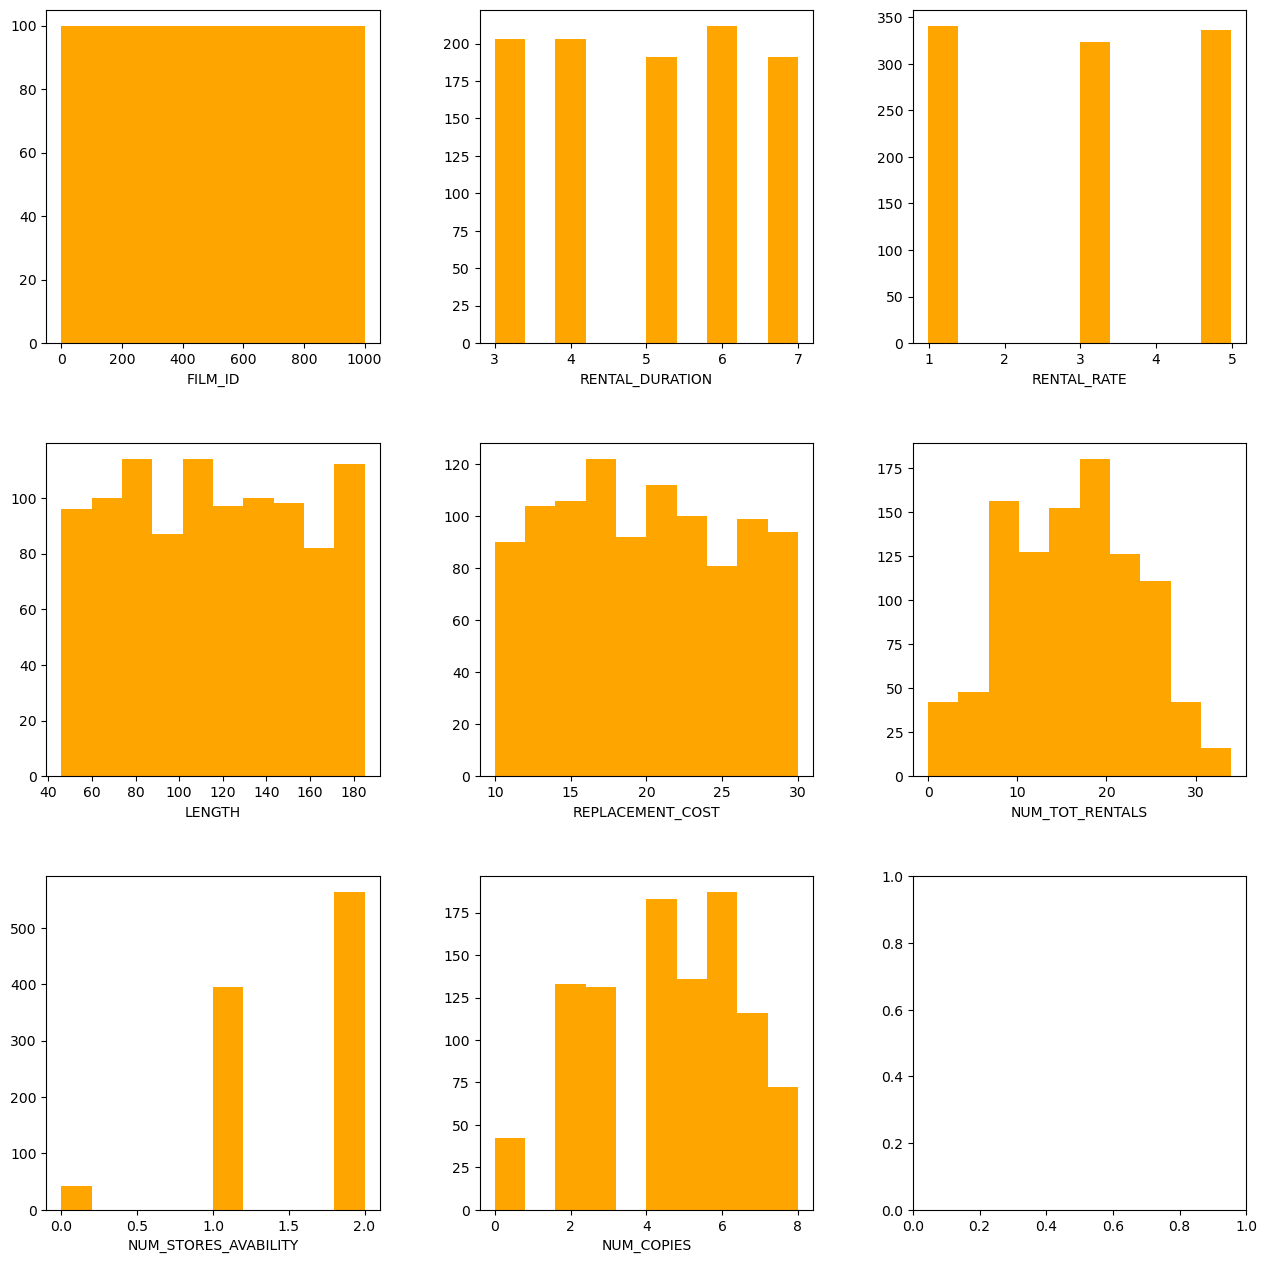

In [9]:
# determine the number of rows and columns in the plot grid
num_cols = 3  # number of columns in the grid
num_rows = (len(df_numeric.columns) + num_cols - 1) // num_cols  # number of rows in the grid

# create the plot grid and plot each histogram in a separate subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
for i, column in enumerate(df_numeric.columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    ax.hist(df_numeric[column], color='orange')
    ax.set_xlabel(column)

# adjust the spacing between subplots and show the figure
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

**Distributions**

<div class="alert alert-block alert-info">
<b>info:</b> Please scroll down to see the distributions of the different numeric variables 
</div>

C:\Users\luisj\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\luisj\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\luisj\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

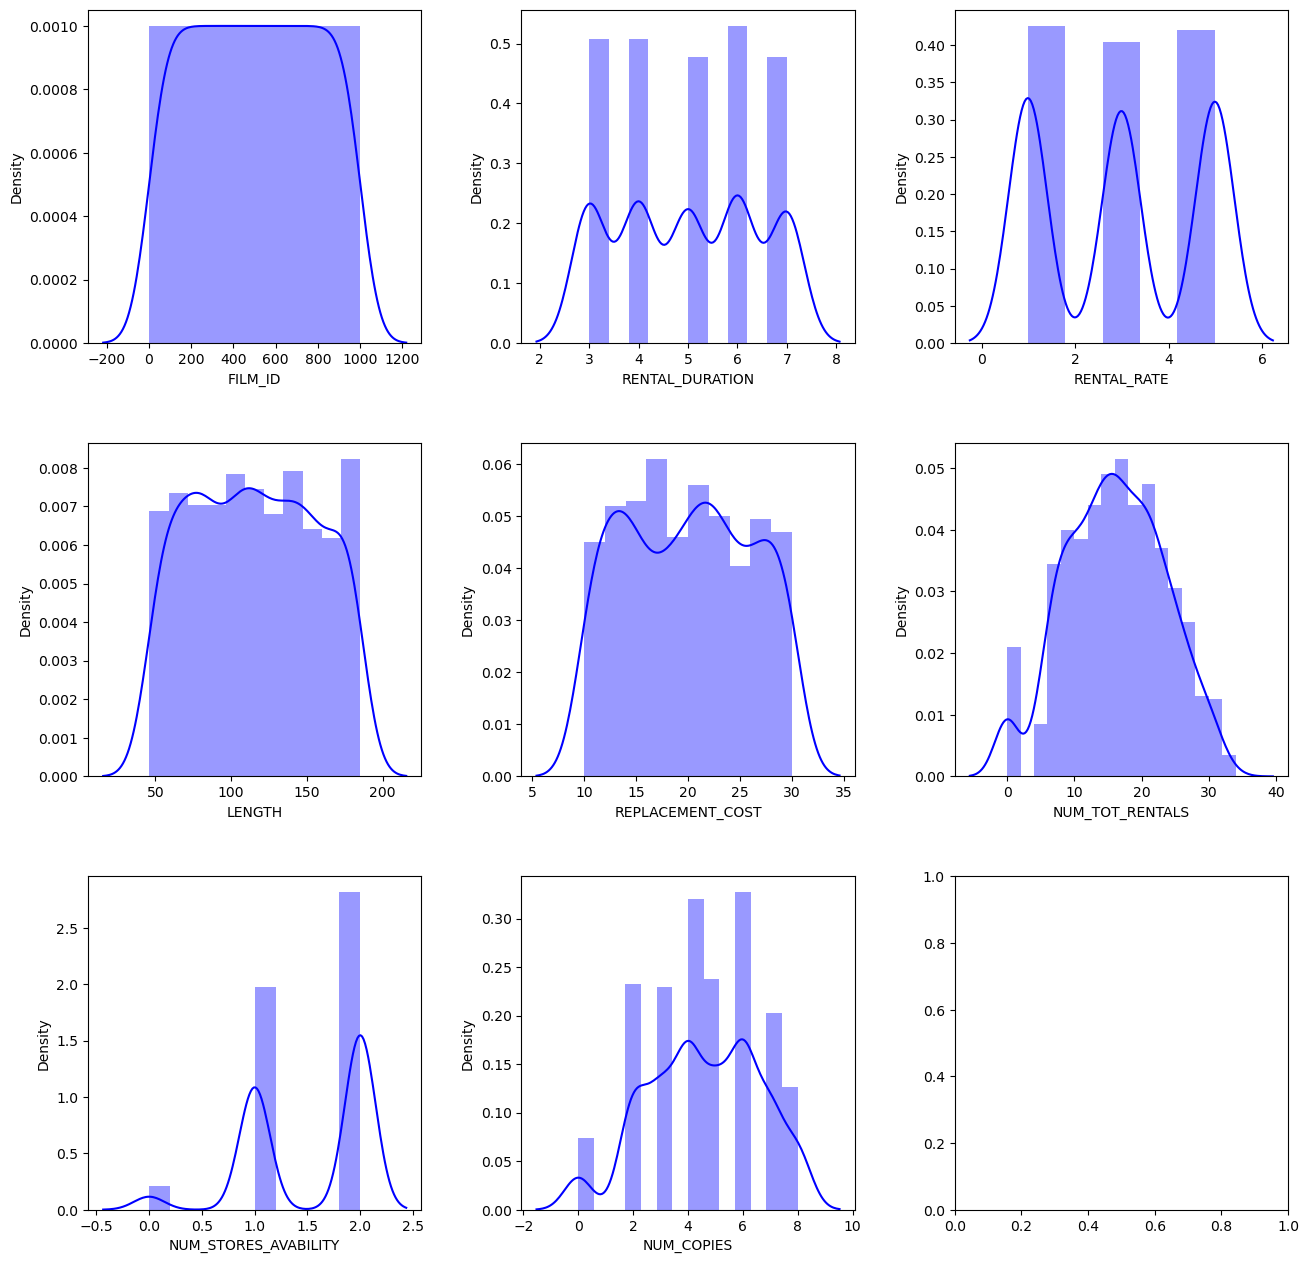

In [10]:
# determine the number of rows and columns in the plot grid
num_cols = 3  # number of columns in the grid
num_rows = (len(df_numeric.columns) + num_cols - 1) // num_cols  # number of rows in the grid

# create the plot grid and plot each distribution in a separate subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
for i, column in enumerate(df_numeric.columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    sns.distplot(df_numeric[column], ax=axes[row_idx, col_idx], kde=True, color='blue')
    axes[row_idx, col_idx].set_xlabel(column)

# adjust the spacing between subplots and show the figure
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

**Boxplots**

<div class="alert alert-block alert-info">
<b>info:</b> Please scroll down to see the boxplots of the different numeric variables 
</div>

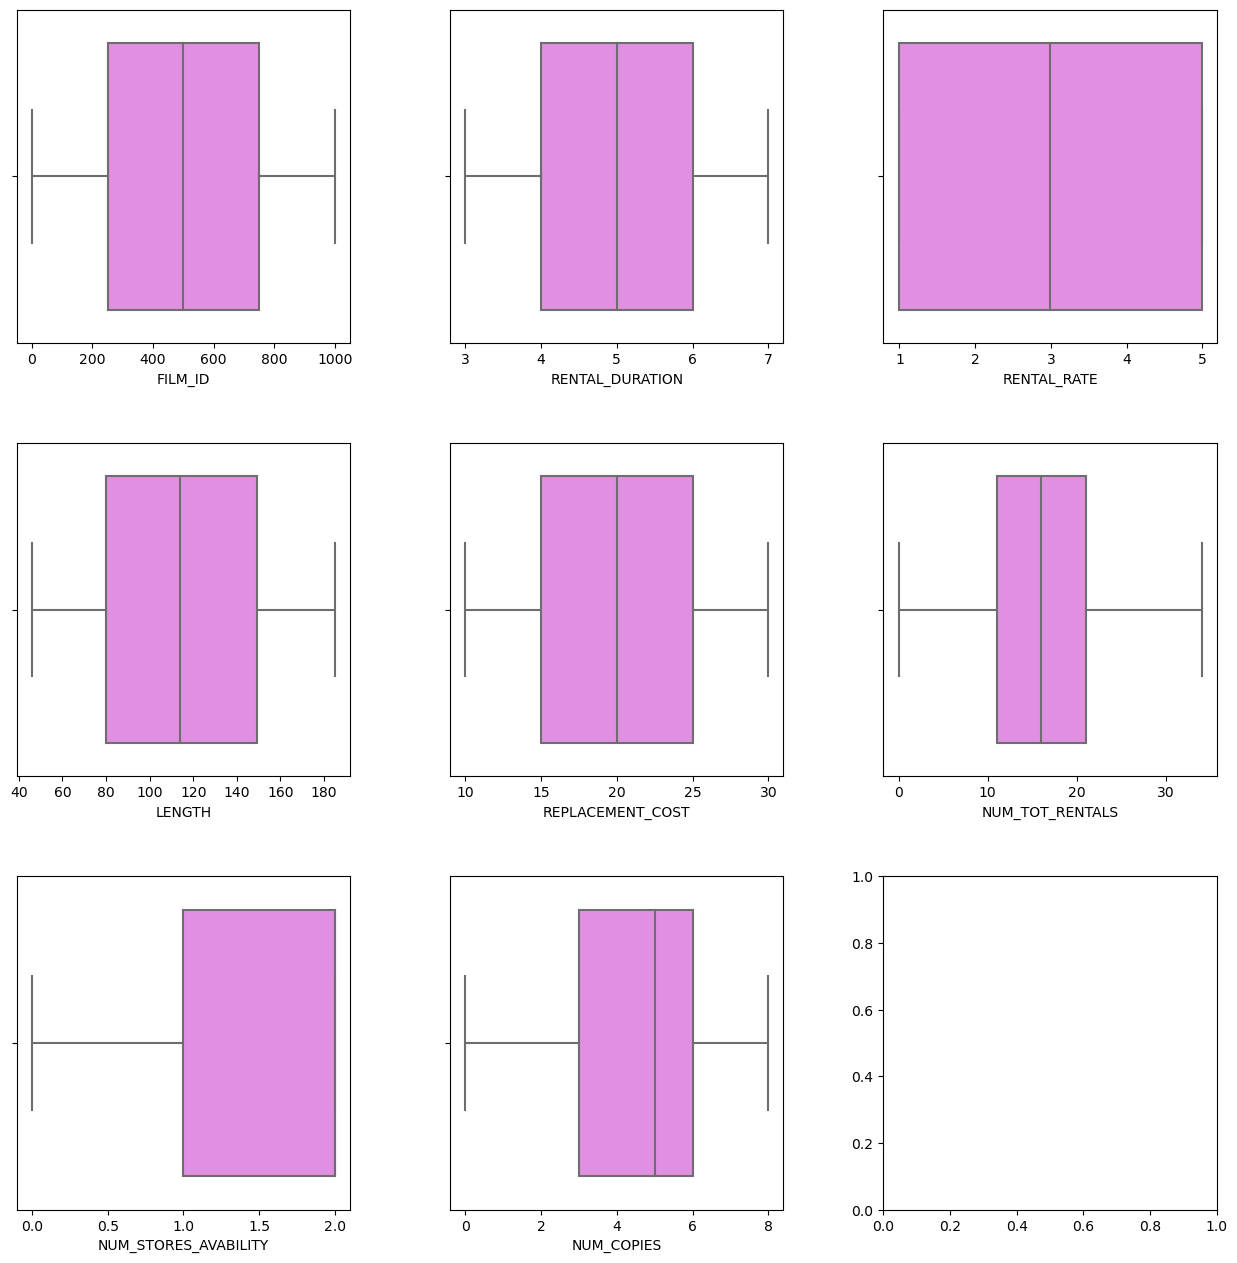

In [11]:
# determine the number of rows and columns in the plot grid
num_cols = 3  # number of columns in the grid
num_rows = (len(df_numeric.columns) + num_cols - 1) // num_cols  # number of rows in the grid

# create the plot grid and plot each distribution in a separate subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
for i, column in enumerate(df_numeric.columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    sns.boxplot(x=df_numeric[column], whis=1.5, ax=axes[row_idx, col_idx], color='violet')
    axes[row_idx, col_idx].set_xlabel(column)

# adjust the spacing between subplots and show the figure
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

**Categorical Values**

<div class="alert alert-block alert-info">
<b>info:</b> Please scroll down to see unique values and a count of how many records in each category are. 
</div>

In [12]:
#Check unique values for each categorical value
for column in df_object.columns:
    print("This feature ", column ," has ", df_object[column].nunique(), " categories \n The single values are: ", df_object[column].unique() )
    print("Here the detail: \n" , df_object[column].value_counts())
    print("\n\n")

This feature  TITLE  has  1000  categories 
 The single values are:  ['AMADEUS HOLY' 'AMERICAN CIRCUS' 'ANTITRUST TOMATOES' 'ARK RIDGEMONT'
 'BAREFOOT MANCHURIAN' 'BERETS AGENT' 'BRIDE INTRIGUE' 'BULL SHAWSHANK'
 'CADDYSHACK JEDI' 'CAMPUS REMEMBER' 'CASUALTIES ENCINO' 'CELEBRITY HORN'
 'CLUELESS BUCKET' 'CROW GREASE' 'DANCES NONE' 'DARKO DORADO'
 'DARN FORRESTER' 'DEVIL DESIRE' 'DRAGON SQUAD' 'DREAM PICKUP'
 'DRIFTER COMMANDMENTS' 'EASY GLADIATOR' 'ENTRAPMENT SATISFACTION'
 'EXCITEMENT EVE' 'FANTASY TROOPERS' 'FIREHOUSE VIETNAM'
 'FOOL MOCKINGBIRD' 'FORREST SONS' 'GLASS DYING' 'GOSFORD DONNIE'
 'GRAIL FRANKENSTEIN' 'HANDICAP BOONDOCK' 'HILLS NEIGHBORS'
 'KISSING DOLLS' 'LAWRENCE LOVE' 'LORD ARIZONA' 'LUST LOCK'
 'MAGNOLIA FORRESTER' 'MIDNIGHT WESTWARD' 'MINDS TRUMAN'
 'MOCKINGBIRD HOLLYWOOD' 'MONTEZUMA COMMAND' 'PARK CITIZEN'
 'PATRIOT ROMAN' 'PRIMARY GLASS' 'QUEST MUSSOLINI' 'REAR TRADING'
 'RINGS HEARTBREAKERS' 'RUGRATS SHAKESPEARE' 'SHRUNK DIVINE' 'SIDE ARK'
 'SKY MIRACLE' 'SOUTH WA

In [13]:
for column in df_numeric.columns:
    iqr = np.percentile(df_numeric[column],75) - np.percentile(df_numeric[column],25) # data['IC1'].quantile(0.75)
    iqr
    # define the limits
    upper_limit = np.percentile(df_numeric[column],75) + 1.5*iqr
    lower_limit = np.percentile(df_numeric[column],25) - 1.5*iqr
    print("\nFeature name: ", column," | Upper limit: ", upper_limit," | Lower limit: ", lower_limit)
    size_exclusion=len(df_numeric.loc[(df_numeric[column]>upper_limit) | (df_numeric[column]<lower_limit)])
    print("Number of exclusions would be ",size_exclusion)
    #print(X_num.where((X_num[X_num[column]]<lower_limit) and (X_num[X_num[column]]>lower_limit)).shape())


Feature name:  FILM_ID  | Upper limit:  1499.5  | Lower limit:  -498.5
Number of exclusions would be  0

Feature name:  RENTAL_DURATION  | Upper limit:  9.0  | Lower limit:  1.0
Number of exclusions would be  0

Feature name:  RENTAL_RATE  | Upper limit:  10.99  | Lower limit:  -5.01
Number of exclusions would be  0

Feature name:  LENGTH  | Upper limit:  253.125  | Lower limit:  -23.875
Number of exclusions would be  0

Feature name:  REPLACEMENT_COST  | Upper limit:  39.989999999999995  | Lower limit:  -0.009999999999996234
Number of exclusions would be  0

Feature name:  NUM_TOT_RENTALS  | Upper limit:  36.0  | Lower limit:  -4.0
Number of exclusions would be  0

Feature name:  NUM_STORES_AVABILITY  | Upper limit:  3.5  | Lower limit:  -0.5
Number of exclusions would be  0

Feature name:  NUM_COPIES  | Upper limit:  10.5  | Lower limit:  -1.5
Number of exclusions would be  0


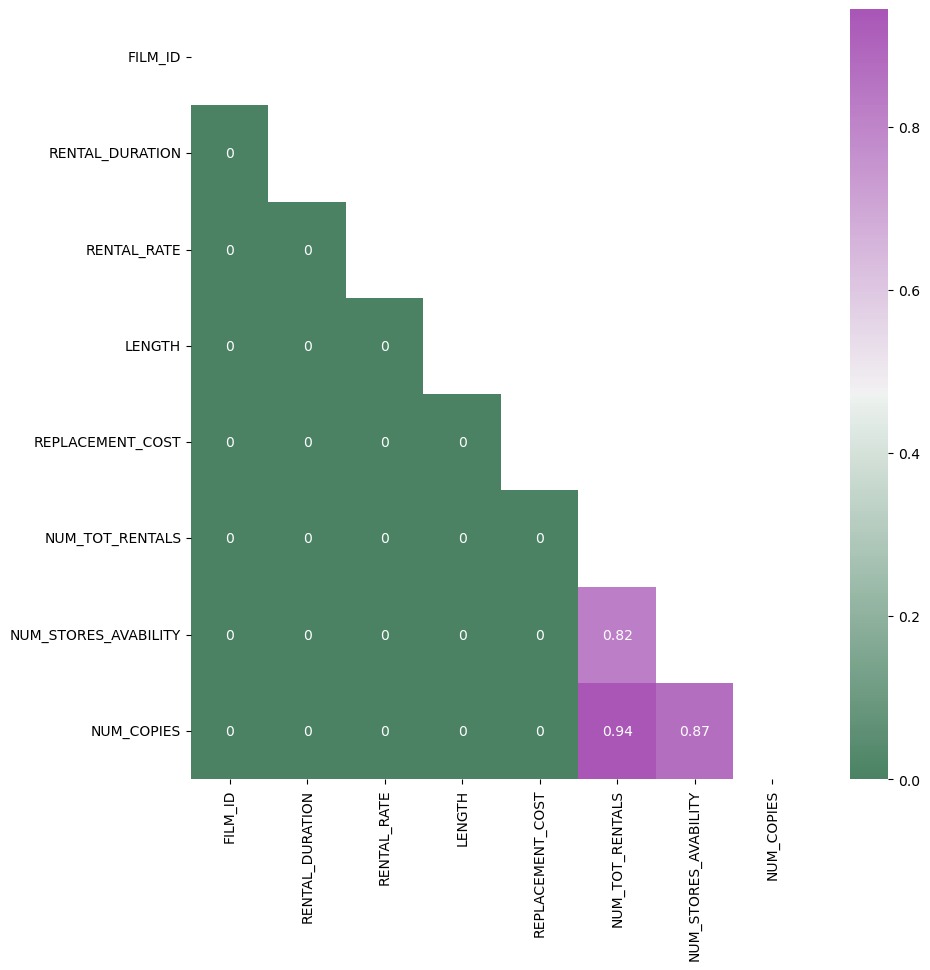

In [15]:
#Check correlation for each feature agaisnt each other
correlations_matrix = df_numeric.corr()
correlations_matrix[(correlations_matrix < 0.75) & (correlations_matrix > -0.75)] = 0
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 10))
colormap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
#sns.set(rc={'figure.figsize':(20,15)})
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True, cmap=colormap)
plt.show()

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

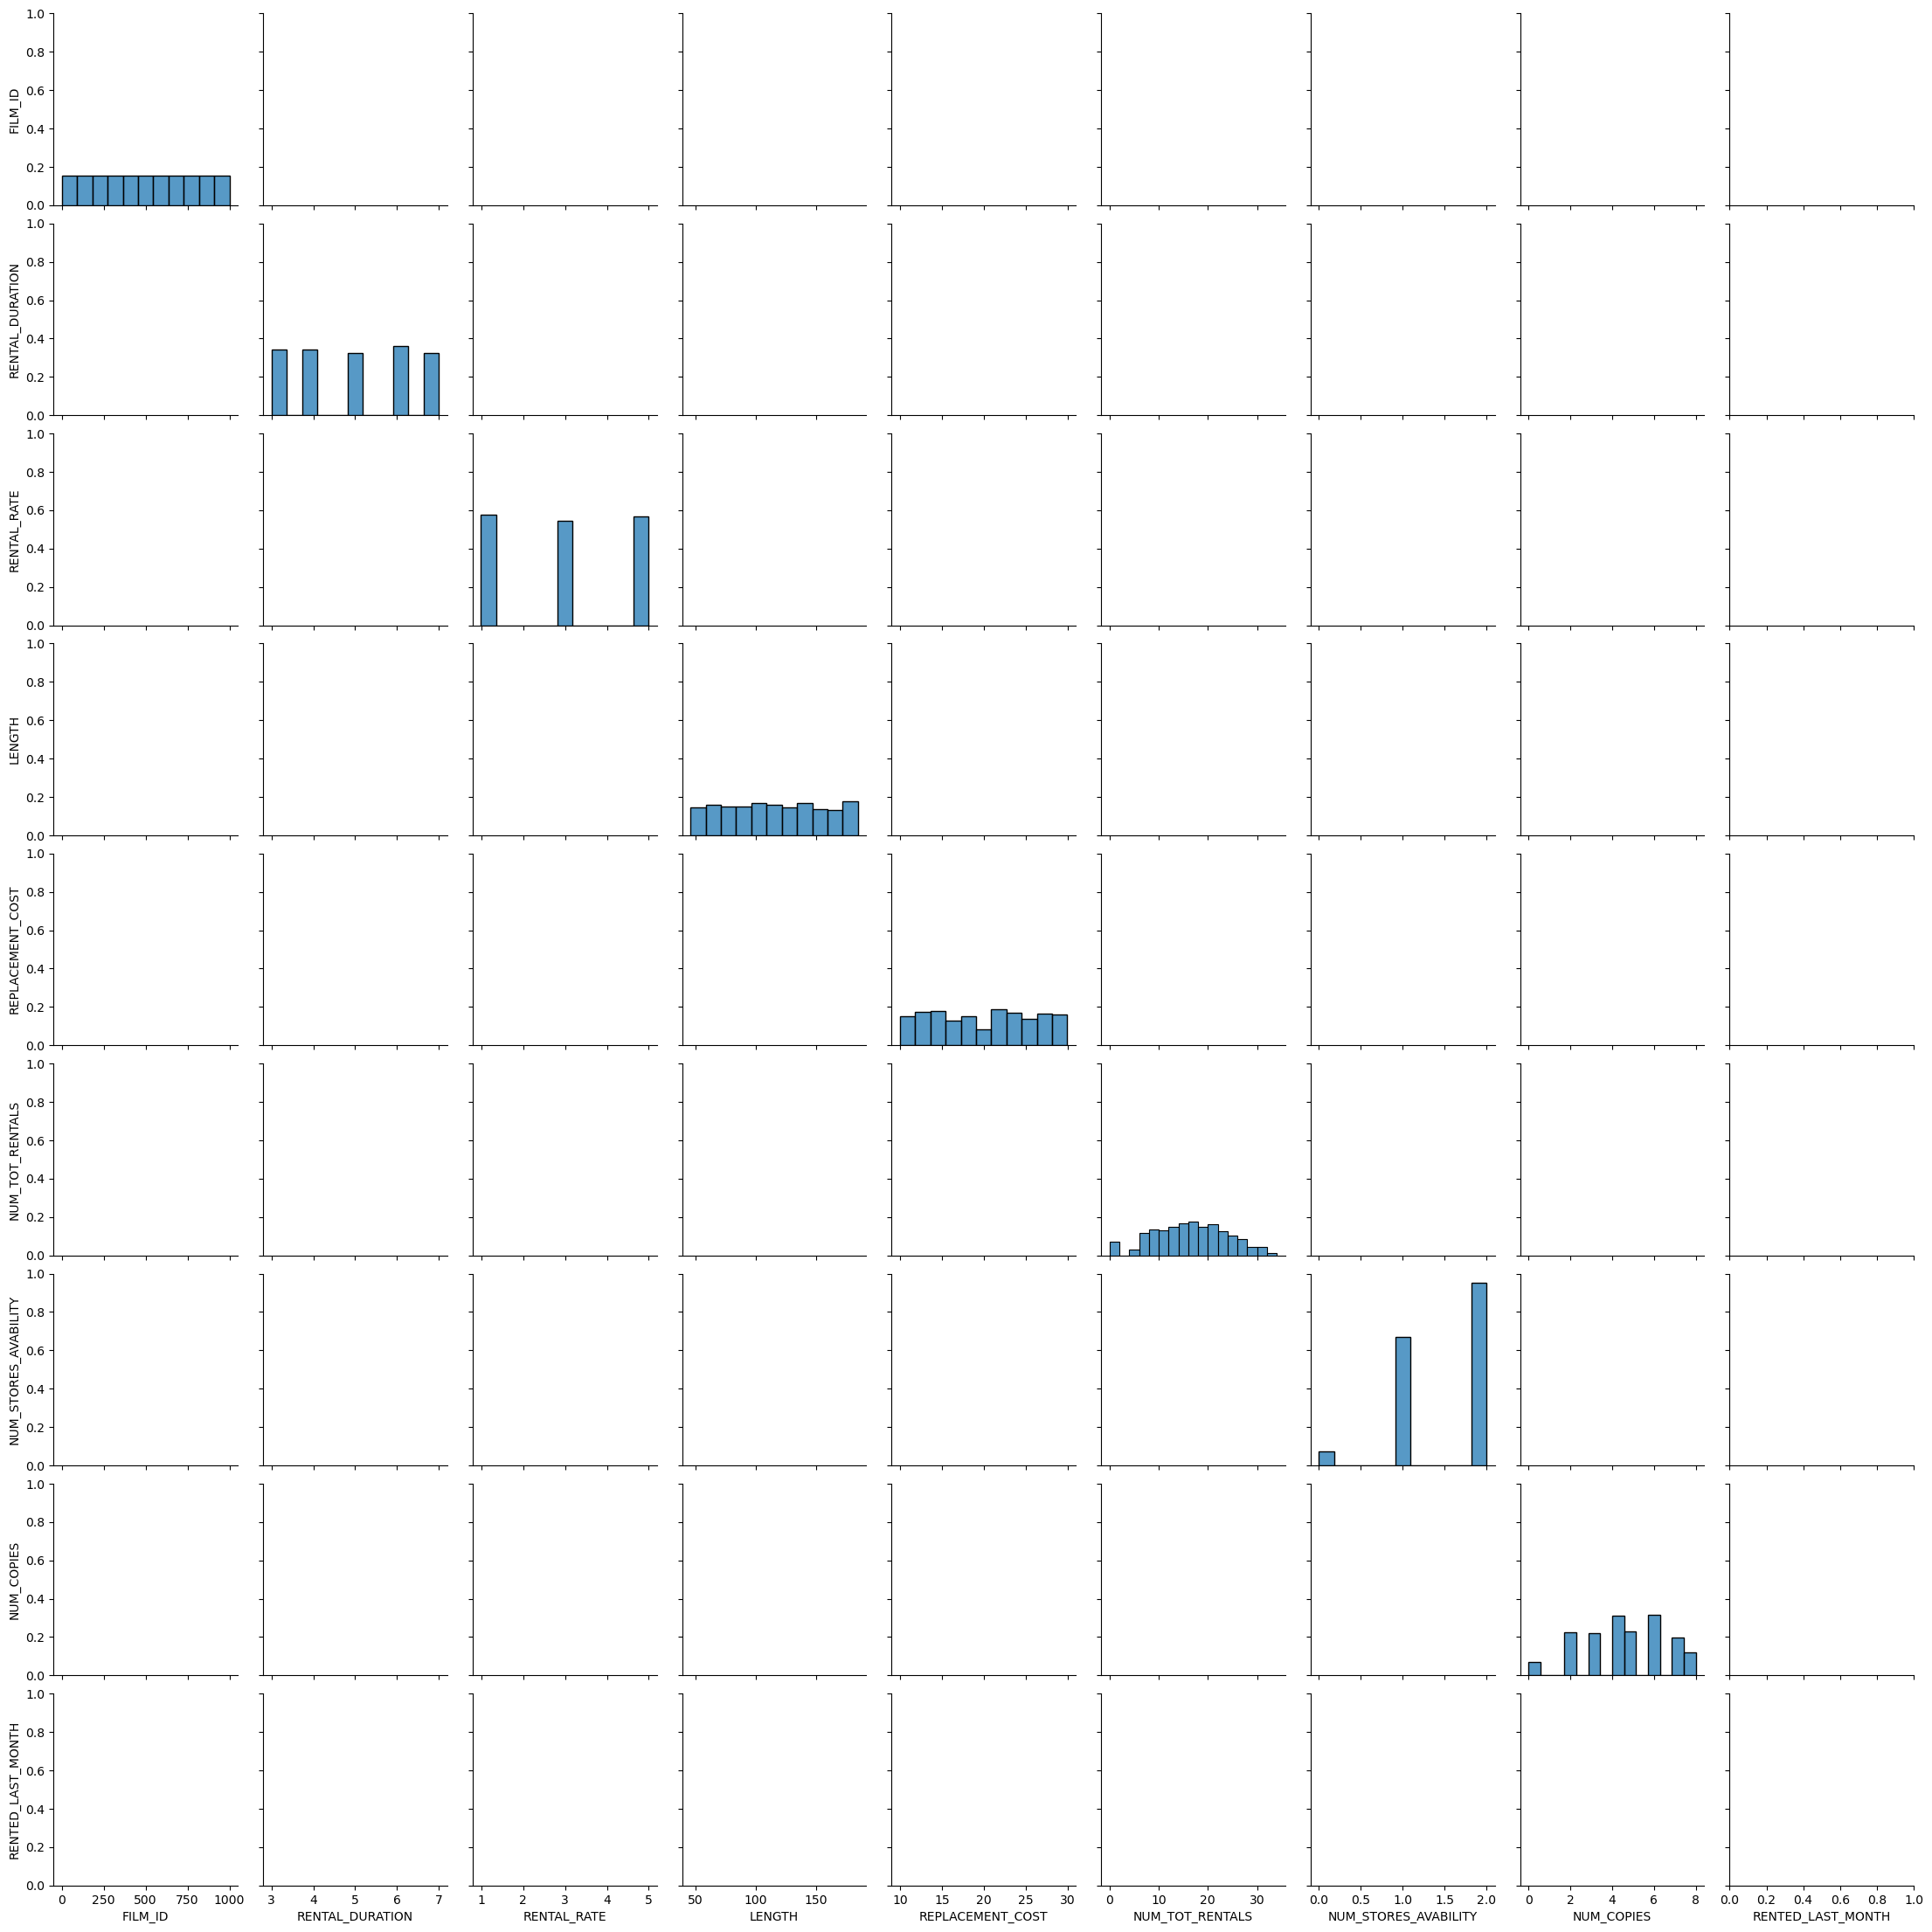

In [20]:
sns.pairplot(df_numeric)

## <span style="color:#7B241C"> 5 Prepare Data </span>.

>Data is prepared, tranform or encoded to apply the model. 

### Select variables relevant for the model
**Categoricals**

    -RATING  
    -CATEGORY  
    
**Numericals**

    -RENTAL_DURATION  
    -RENTAL_RATE  
    -LENGTH  
    -REPLACEMENT_COST  
    -NUM_TOT_RENTALS  
    -NUM_STORES_AVABILITY  
    -NUM_COPIES  I drop this variable it has a 0.94 correlation with NUM_TOT_RENTALS
    
 **Boolean**
 
    -COMMENTARY
    -DELETED_SCENES  
    -BEHIND_THE_SCENES   
    -TRAILERS      
 
 **OUR TARGET IS: (12 points goes to...)**
 >RENTED_LAST_MONTH     


In [26]:
df_object_selected=data_3[['RATING','CATEGORY']]
df_boolean_selected=data_3[['COMMENTARY','DELETED_SCENES','BEHIND_THE_SCENES','TRAILERS']]
df_numeric_selected=data_3[['RENTAL_DURATION','RENTAL_RATE','LENGTH','REPLACEMENT_COST','NUM_TOT_RENTALS','NUM_STORES_AVABILITY']]
df_Target=data_3[['RENTED_LAST_MONTH']]

### Encoding

In [27]:
# Create a dictionary that maps old categories to new categories
mapping = {
    "G": "LOWPROTECTION",
    "PG": "MEDPROTECTION",
    "PG-13": "MEDPROTECTION",
    "NC-17": "HIGHPROTECTION",
    "R": "HIGHPROTECTION"
}
# Use the replace() method to map old categories to new categories
df_object_selected["RATING"] = df_object_selected["RATING"].replace(mapping)
#df_object_selected.head()
df_object_selected["RATING"].unique()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17648\2096625207.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_object_selected["RATING"] = df_object_selected["RATING"].replace(mapping)


array(['MEDPROTECTION', 'HIGHPROTECTION', 'LOWPROTECTION'], dtype=object)

In [28]:
df_object_encoded = pd.get_dummies(df_object_selected, columns=['RATING', 'CATEGORY'], drop_first=False)
df_object_encoded.head(5)

,RATING_HIGHPROTECTION,RATING_LOWPROTECTION,RATING_MEDPROTECTION,CATEGORY_Action,CATEGORY_Animation,CATEGORY_Children,CATEGORY_Classics,CATEGORY_Comedy,CATEGORY_Documentary,CATEGORY_Drama,CATEGORY_Family,CATEGORY_Foreign,CATEGORY_Games,CATEGORY_Horror,CATEGORY_Music,CATEGORY_New,CATEGORY_Sci-Fi,CATEGORY_Sports,CATEGORY_Travel
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Transform numeric data

make numeric features more "normal"

In [29]:
transformer = StandardScaler().fit(df_numeric_selected)
x_normalized = transformer.transform(df_numeric_selected)
df_numeric_trans = pd.DataFrame(x_normalized)
df_numeric_trans.columns = df_numeric_selected.columns
df_numeric_trans.head()

,RENTAL_DURATION,RENTAL_RATE,LENGTH,REPLACEMENT_COST,NUM_TOT_RENTALS,NUM_STORES_AVABILITY
0,0.719374,-1.209308,-0.056229,0.166341,0.674571,0.829372
1,-1.406855,1.221461,0.339751,-0.329706,0.810711,0.829372
2,0.010631,0.006077,1.304951,-1.321802,-0.822963,-0.902093
3,0.719374,-1.209308,-1.169922,0.993087,-2.184359,-2.633558
4,0.719374,0.006077,0.339751,-0.660405,0.266153,0.829372


In [30]:
data_5=pd.concat([df_numeric_trans, df_object_encoded,df_boolean_selected,df_Target], axis=1)
data_5.reset_index()

,index,RENTAL_DURATION,RENTAL_RATE,LENGTH,REPLACEMENT_COST,NUM_TOT_RENTALS,NUM_STORES_AVABILITY,RATING_HIGHPROTECTION,RATING_LOWPROTECTION,RATING_MEDPROTECTION,...,CATEGORY_Music,CATEGORY_New,CATEGORY_Sci-Fi,CATEGORY_Sports,CATEGORY_Travel,COMMENTARY,DELETED_SCENES,BEHIND_THE_SCENES,TRAILERS,RENTED_LAST_MONTH
0,0,0.719374,-1.209308,-0.056229,0.166341,0.674571,0.829372,0,0,1,...,0,0,0,0,0,False,True,True,False,True
1,1,-1.406855,1.221461,0.339751,-0.329706,0.810711,0.829372,1,0,0,...,0,0,0,0,0,False,False,True,False,True
2,2,0.010631,0.006077,1.304951,-1.321802,-0.822963,-0.902093,1,0,0,...,0,0,0,0,0,False,True,False,True,False
3,3,0.719374,-1.209308,-1.169922,0.993087,-2.184359,-2.633558,1,0,0,...,0,0,0,0,0,False,True,True,True,False
4,4,0.719374,0.006077,0.339751,-0.660405,0.266153,0.829372,0,1,0,...,0,0,0,0,0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,1.428118,-1.209308,-1.664897,-1.652500,-0.550684,-0.902093,0,0,1,...,0,0,0,0,1,False,False,True,True,False
996,996,-1.406855,0.006077,-0.749194,0.993087,-0.550684,-0.902093,1,0,0,...,0,0,0,0,1,False,True,True,False,True
997,997,1.428118,-1.209308,-1.491655,-0.991103,0.674571,0.829372,1,0,0,...,0,0,0,0,1,False,False,True,False,False
998,998,1.428118,0.006077,0.587238,1.158437,-0.142266,0.829372,1,0,0,...,0,0,0,0,1,False,False,True,True,False


## <span style="color:#7B241C"> 6 Evaluate Models </span>

In [52]:
X=data_5.drop(columns=['RENTED_LAST_MONTH'])
Y=data_5[['RENTED_LAST_MONTH']]
#X.head(5)

In [53]:
# We separate training and testing datasets and correspondant targets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

In [54]:
len(X_train)

700

In [55]:
# We traing the training dataset using Logistic Regression (multiclass classification)
classification = LogisticRegression(random_state=0).fit(X_train, y_train)

C:\Users\luisj\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
# We predict on the testing dataset
predictions = classification.predict(X_test)

## <span style="color:#7B241C"> 7 Modeling </span>

In [47]:
pd.Series(predictions).value_counts()

False    299
True       1
dtype: int64

In [48]:
y_test.value_counts()

RENTED_LAST_MONTH
False                253
True                  47
dtype: int64

In [49]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[252,   1],
       [ 47,   0]], dtype=int64)

In [50]:
cm1 = confusion_matrix(predictions,y_test)

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
#disp.plot(cmap='Blues')
#sns.heatmap(cm, annot=True,fmt='g')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

NameError: name 'ConfusionMatrixDisplay' is not defined

In [56]:
# Accuracy
classification.score(X_test, y_test)

0.84

In [57]:
# Accuracy
from sklearn.metrics import accuracy_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, predictions)))


Accuracy: 0.84



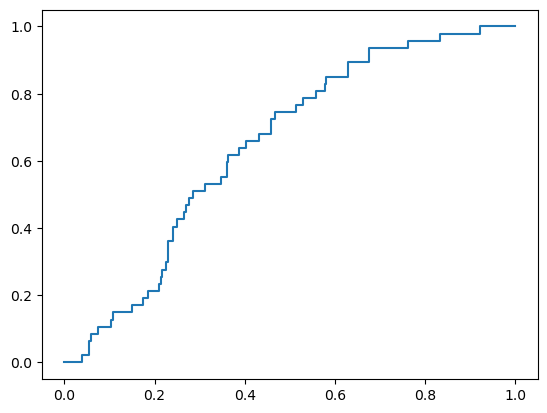

In [58]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_pred_proba = classification.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr)